In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code import FigureSingleCellData
from jtb_2022_code.figure_constants import *

/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2023-04-20 15:53:57 2 Preprocessing methods selected: Predictor method zscore [limit 10] Response method zscore [limit 10] Pre-TFA expression method robustscaler [limit 20] 


In [3]:
## LOAD AND PROCESS VELOCITY AND DECAY ###
data = FigureSingleCellData()
data.decay_data_all()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


AnnData object with n_obs × n_vars = 173347 × 5727
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'n_genes', 'CC', 'RP', 'RiBi', 'iESR', 'Mito', 'Cell Cycle', 'Other', 'program_1_time', 'program_0_time', 'program_rapa_time_denoised', 'program_cc_time_denoised'
    var: 'n_cells', 'n_counts', 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'Cell Cycle', 'Other', 'category', 'leiden', 'programs', 'cell_cycle_decay', 'cell_cycle_decay_se', 'cell_cycle_alpha', 'rapamycin_decay', 'rapamycin_decay_se', 'rapamycin_alpha'
    uns: 'cell_cycle_decay', 'cell_cycle_window_decay', 'log1p', 'neighbors', 'pca', 'programs', 'rapamycin_decay', 'rapamycin_window_decay', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'cell_cycle_window_alpha', 'cell_cycle_window_decay', 'cell_cycle_window_decay_se', 'gene_program_mi', 'rapamycin_window_alpha', 'rapamycin_window_decay', 'rapamycin_window_decay_se'
    layers: 'counts', 'decay_constants'
    obsp: 'connectiv

In [5]:
import gc

ANIMATION_GENES = [
    ("YKR039W", RAPA_VELO_LAYER, 'rapamycin'),
    ("YOR063W", RAPA_VELO_LAYER, 'rapamycin'),
    ("YKL164C", CC_VELO_LAYER, 'cell_cycle'),
    ("YDR224C", CC_VELO_LAYER, 'cell_cycle'),
    ("YGR108W", CC_VELO_LAYER, 'cell_cycle')
]

if 'rapamycin_window_decay' not in data.expt_data[(2, "fpr1")].varm:
    for k in data.expts:
        _decay = data.decay_data(*k)

        for vark in ['rapamycin_window_decay', 'cell_cycle_window_decay']:
            data.expt_data[k].varm[vark] = _decay.varm[vark]
            data.expt_data[k].uns[vark] = _decay.uns[vark]
            
        for vark in ['rapamycin_decay', 'rapamycin_decay_se', 'cell_cycle_decay', 'cell_cycle_decay_se']:
            data.expt_data[k].var[vark] = _decay.var[vark].copy()
            
        _idx = [_decay.var_names.get_loc(x[0]) for x in ANIMATION_GENES]
        
        data.expt_data[k].obsm['FIG4_EXPR'] = _decay.X[:, _idx]
        data.expt_data[k].obsm[f'FIG4_{RAPA_VELO_LAYER}'] = _decay.layers[RAPA_VELO_LAYER][:, _idx]
        data.expt_data[k].obsm[f'FIG4_{CC_VELO_LAYER}'] = _decay.layers[CC_VELO_LAYER][:, _idx]

        del _decay
        gc.collect()

Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_1_WT.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_1_fpr1.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_2_WT.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_2_fpr1.h5ad


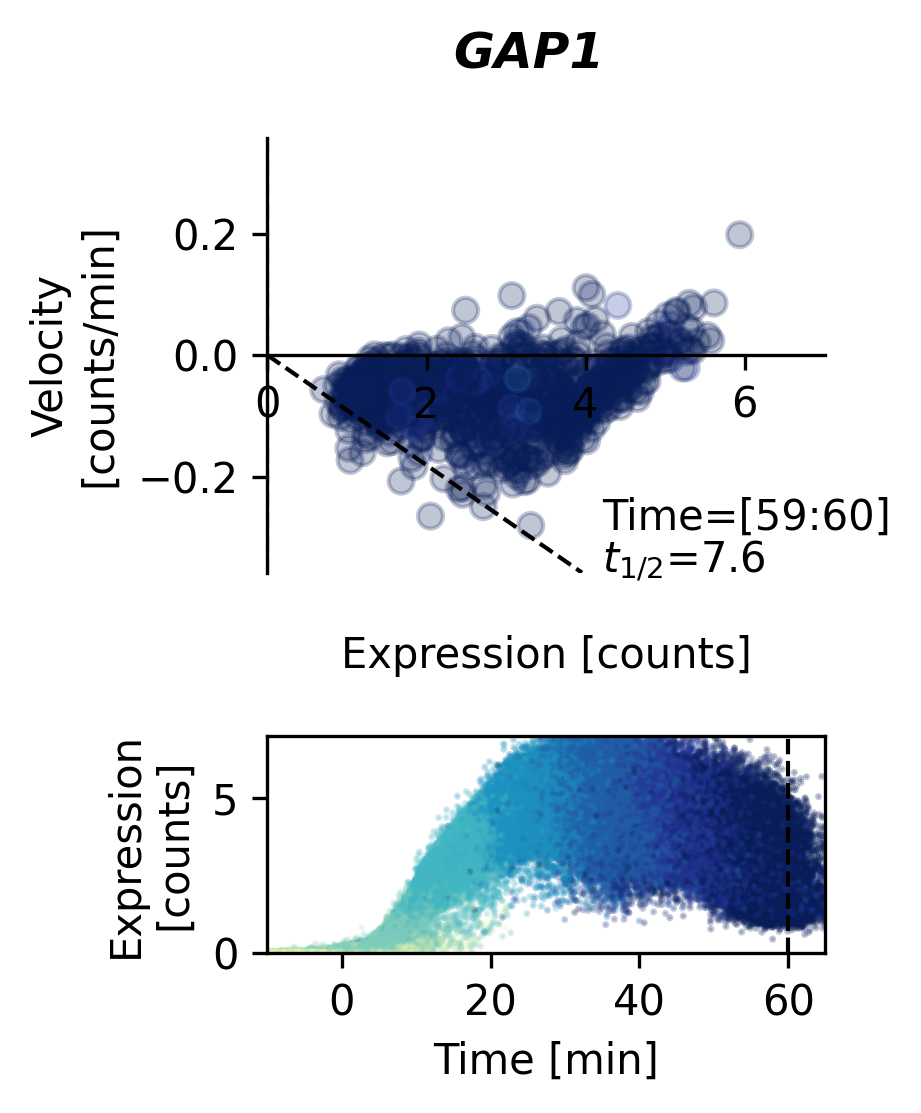

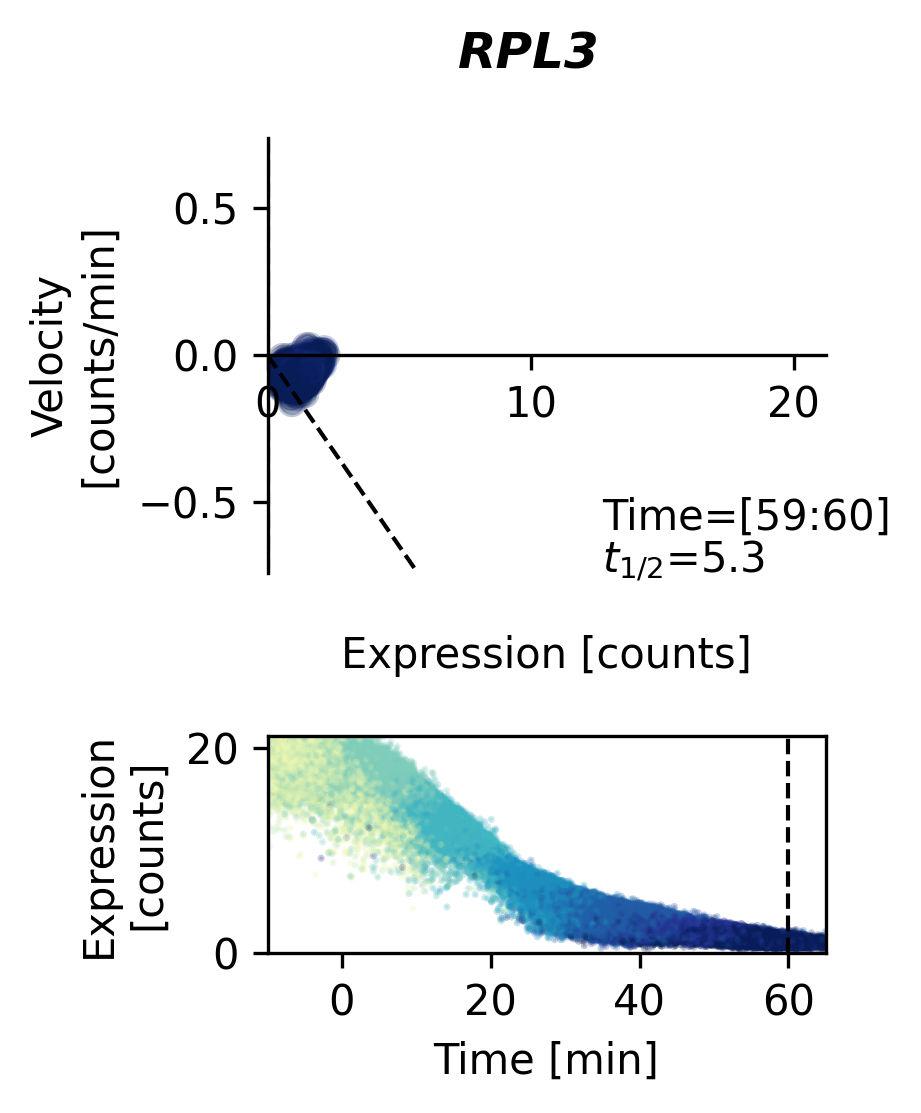

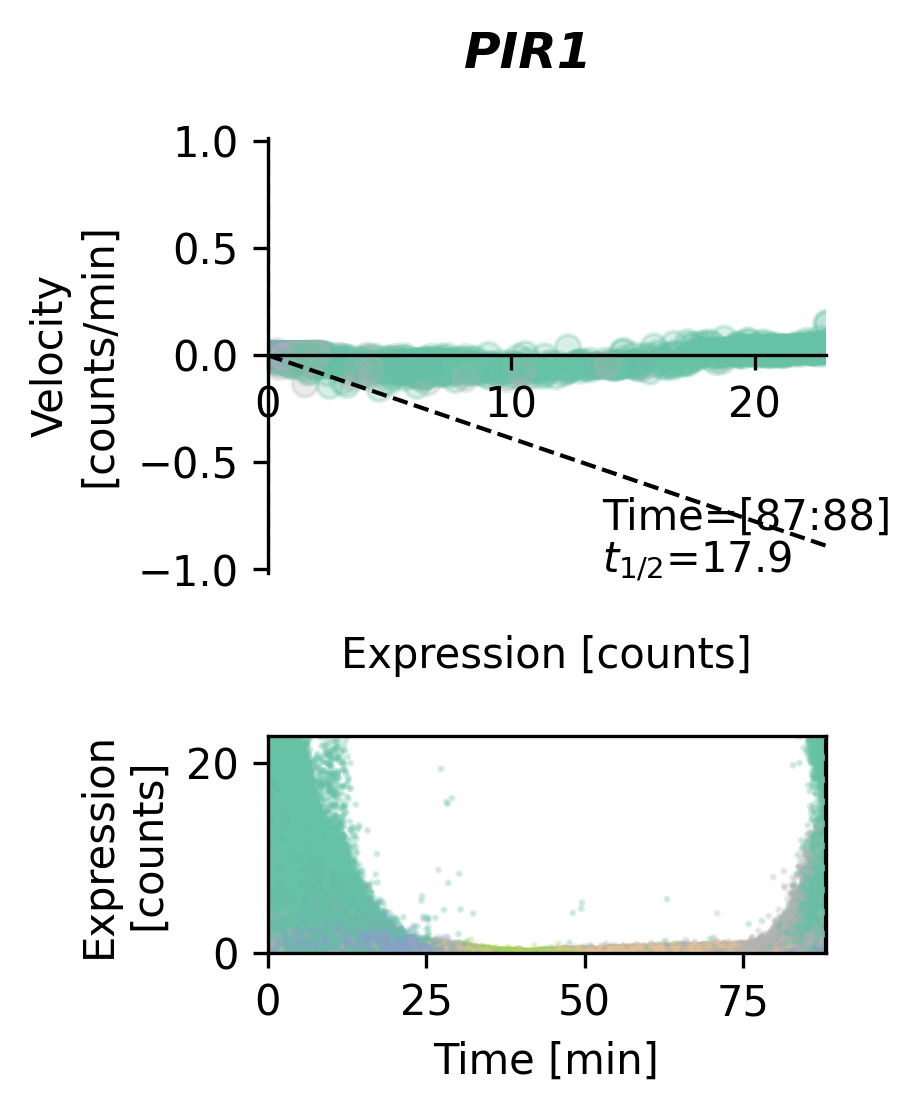

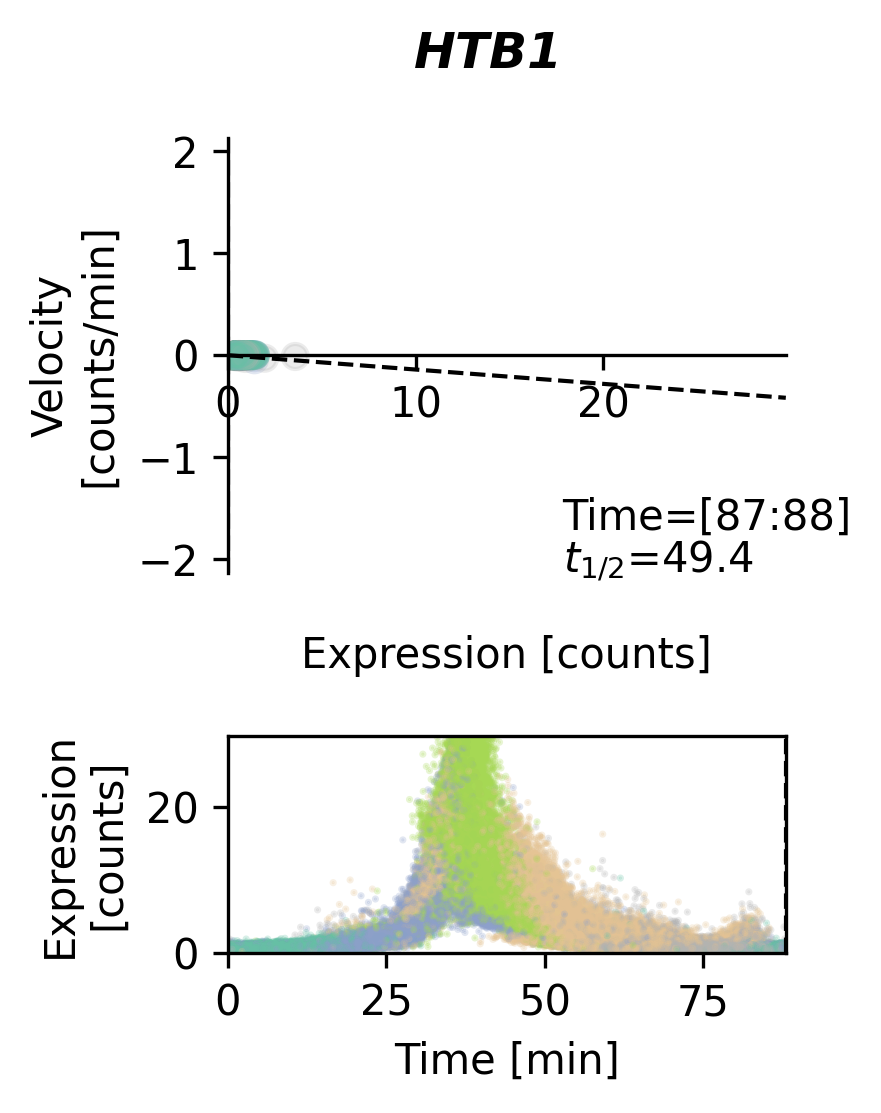

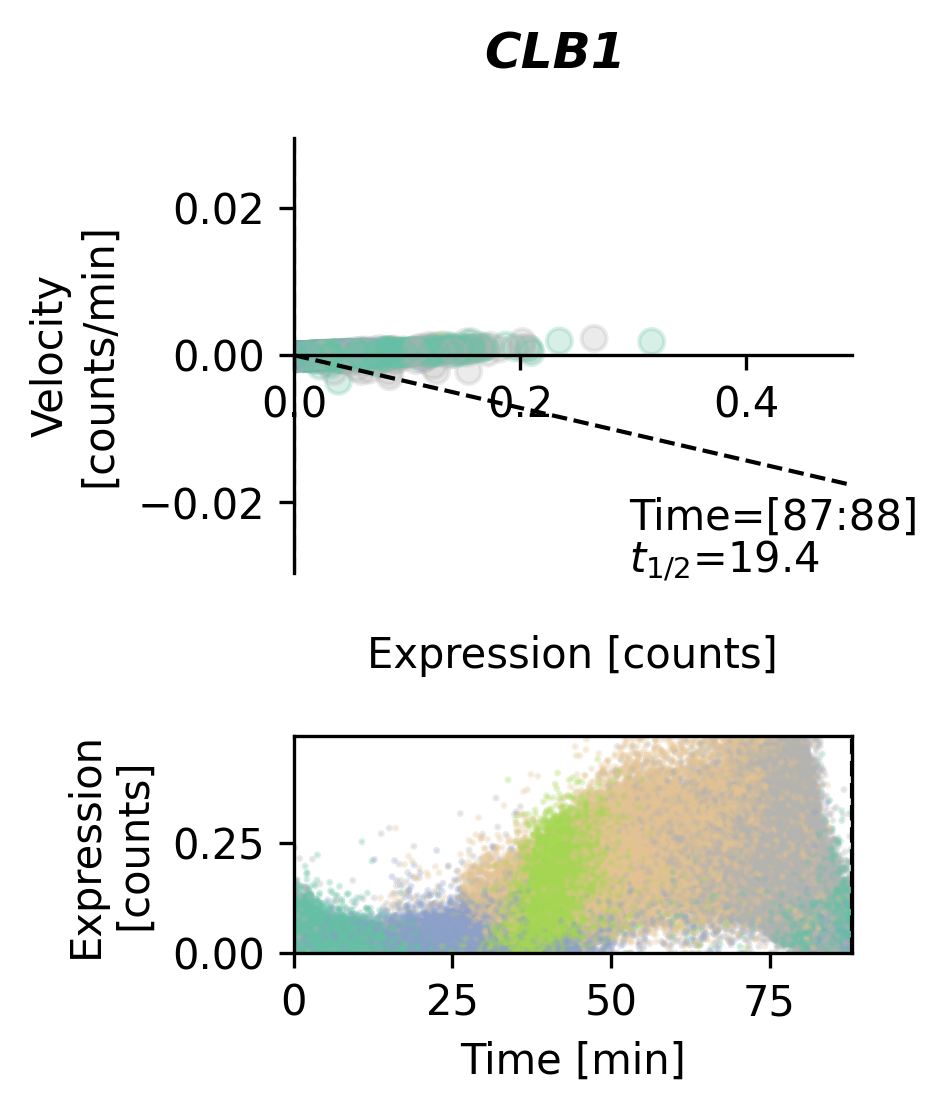

In [6]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.decay_common import _halflife

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.stats
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation

import gc

#os.system("module load ffmpeg/4.2.4")
#plt.rcParams['animation.ffmpeg_path'] = '/share/apps/ffmpeg/4.2.4/bin/ffmpeg'

TIME_LIMITS = [-10, 65]
VLINE_X = 0

def _gene_data(gene, rapamycin=False, cell_cycle=False, layer='FIG4_EXPR'):    
    g_data = np.concatenate([data.expt_data[(i, "WT")].obsm[layer][:, [gene == x[0] for x in ANIMATION_GENES]].flatten()
                             for i in range(1, 3)])
    t_data = np.concatenate([data.expt_data[(i, "WT")].obs[RAPA_TIME_COL if rapamycin else CC_TIME_COL].values
                             for i in range(1, 3)])
    
    if rapamycin:
        pools = np.concatenate([data.expt_data[(i, "WT")].obs['Pool'].map({k: v for k, v in zip(range(1, 9), pool_palette())}).values
                                for i in range(1, 3)])
    elif cell_cycle:
        pools = np.concatenate([data.expt_data[(i, "WT")].obs['CC'].map({k: v for k, v in zip(CC_COLS, cc_palette())}).values
                                for i in range(1, 3)])
        
    else:
        pools = None
           
    return g_data, t_data, pools

for g, layer, prog in ANIMATION_GENES:

    rgen = np.random.default_rng(100)

    rep_colors = ['darkslateblue', 'darkgoldenrod', 'black']

    fig_refs = {}

    fig, axd = plt.subplot_mosaic([['.', 'decay', '.'],['.', 'expr', '.']],
                                  gridspec_kw=dict(width_ratios=[0.25, 1, 0.25], 
                                                   height_ratios=[1, 0.5,],
                                                   wspace=0.5, hspace=0.5), 
                                  figsize=(4 * 1.2, 3 * 1.2), dpi=300)

    fig.suptitle(
        data.gene_common_name(g), 
        fontweight='bold',
        fontstyle='italic'
    )

    expr_data, time_data, color_data = _gene_data(
        g,
        rapamycin=prog=='rapamycin',
        cell_cycle=prog=='cell_cycle'
    )
    
    velo_data, _, _ = _gene_data(g, layer=f'FIG4_{layer}')

    # Pull decay data out into a dict keyed by times
    decay_data = {
        t: [
            data.expt_data[(i, "WT")].varm[f'{prog}_window_decay'][data.expt_data[(i, "WT")].var_names == g, i]
            for i in range(1, 3)
        ] + [data.all_data.varm[f'{prog}_window_decay'][data.all_data.var_names == g, i].flatten()]
        for i, t in enumerate(data.expt_data[(1, "WT")].uns[f'{prog}_window_decay']['times'])
    }

    xlims = [0, np.nanquantile(expr_data, [0.995])]
    ylims = np.nanquantile(velo_data, [0.005, 0.995]).tolist()

    # Make symmetric around 0
    if np.abs(ylims[0]) > np.abs(ylims[1]):
        ylims[1] = np.abs(ylims[0])
    elif np.abs(ylims[0]) < np.abs(ylims[1]):
        ylims[0] = -1 * np.abs(ylims[1])

    _base_plot = axd['decay'].scatter(
        [],
        [],
        c=[],
        alpha=0.25
    )

    _op = np.arange(time_data.shape[0])
    rgen.shuffle(_op)

    _base_expr = axd['expr'].scatter(
        time_data[_op],
        expr_data[_op],
        c=color_data[_op],
        alpha=0.25,
        s=0.5
    )

    if prog == 'rapamycin':
        axd['expr'].set_xlim(-10, 65)
    else:
        axd['expr'].set_xlim(0, CC_LENGTH)

    axd['expr'].set_ylim(*xlims)
    axd['expr'].set_xlabel("Time [min]")
    axd['expr'].set_ylabel("Expression\n[counts]")

    _base_expr_line = axd['expr'].axvline(
        data.all_data.uns[f'{prog}_window_decay']['times'][0],
        0,
        1,
        linestyle='--',
        linewidth=1.0,
        c='black'
    )

    _base_annotate = axd['decay'].annotate(
        f"Time=[:]",
        (0.60, 0.05),
        xycoords='axes fraction',
        fontsize='large',
        fontweight='bold'
    )

    def _init_animation():
        axd['decay'].set_xlim(*xlims)
        axd['decay'].set_ylim(*ylims)
        axd['decay'].spines['left'].set_position(('axes', 0.0))
        axd['decay'].spines['right'].set_color('none')
        axd['decay'].spines['bottom'].set_position(('data', 0.0))
        axd['decay'].spines['top'].set_color('none')
        axd['decay'].axvline(VLINE_X, 0, 1, linestyle='--', linewidth=1.0, c='black')
        axd['decay'].set_ylabel("Velocity\n[counts/min]")
        axd['decay'].set_xlabel("Expression [counts]", labelpad=50)

        return _base_plot, _base_annotate

    def _update_animation(frame_id):
        
        if frame_id is None:
            return axd['decay'].get_children()

        _left = frame_id - 0.5
        _right = frame_id + 0.5

        _time_mask = np.logical_and(time_data >= _left, time_data < _right)

        _expr_slice = expr_data[_time_mask]
        _velo_slice = velo_data[_time_mask]
        _color_slice = color_data[_time_mask]

        _decay_slice = decay_data[frame_id]

        _n_obs = len(_expr_slice)

        axd['decay'].clear()
        _init_animation()

        _base_expr_line.set_data(
            [[_right, _right],
             [0, 1]]
        )

        _base_annotate = axd['decay'].annotate(
            f"Time=[{int(_left)}:{int(_right)}]",
            (0.60, 0.1),
            xycoords='axes fraction',
            fontsize='medium'
        )

        if _n_obs == 0:
            axd['decay'].annotate(
                f"$t_{{1/2}}$=",
                (0.60, 0.0),
                xycoords='axes fraction',
                fontsize='medium'
            )
            return _base_annotate,

        axd['decay'].annotate(
            f"$t_{{1/2}}$={_halflife(_decay_slice[2])[0]:.1f}",
            (0.60, 0.0),
            xycoords='axes fraction',
            fontsize='medium'
        )

        axd['decay'].axline(
            (0, 0),
            slope = -1 * _decay_slice[2],
            c='black',
            linestyle='--',
            linewidth=1.0
        )

        overplot_shuffle = np.arange(_n_obs)
        rgen.shuffle(overplot_shuffle)

        _base_plot = axd['decay'].scatter(
            _expr_slice[overplot_shuffle],
            _velo_slice[overplot_shuffle],
            c=_color_slice[overplot_shuffle],
            alpha=0.25
        )

        return _base_plot, _base_annotate

    _frames = data.all_data.uns[f'{prog}_window_decay']['times'].tolist()
    
    if prog == "rapamycin":
        _frames = _frames + [None] * 12

    animator = FuncAnimation(
        fig,
        _update_animation,
        frames=_frames,
        init_func=_init_animation,
        blit=True
    )

    animator.save(
        os.path.join(
            "Animations",
            f'{g}_decay_time_animation.gif'
        ),
        writer = 'pillow',
        fps = 4,
        savefig_kwargs = {
            "facecolor": "white"
        }
    )